# 1: Environment Check

In [1]:
# Check Python version
import sys
print("🐍 Python version:", sys.version)

🐍 Python version: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]


# 2: Verify Ollama Is Working

In [2]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3", temperature=0)

response = llm.invoke("Say hello in one short sentence.")
print("🤖 Ollama response:")
print(response.content)

🤖 Ollama response:
Hello!


# 3: Test Web Scraper Alone

In [3]:
from scraper import scrape_website

test_url = "https://example.com"

content = scrape_website(test_url)

print("📄 Scraped content length:", len(content))
print("\n🔍 Preview:")
print(content)

📄 Scraped content length: 142

🔍 Preview:
Example Domain Example Domain This domain is for use in documentation examples without needing permission. Avoid use in operations. Learn more


# 4: Test Embeddings + FAISS (No Graph Yet)

In [4]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = OllamaEmbeddings(model="nomic-embed-text")

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150
)

chunks = splitter.split_text(content)

vector_store = FAISS.from_texts(chunks, embeddings)

print("📦 FAISS index created")
print("🔢 Total vectors:", vector_store.index.ntotal)

📦 FAISS index created
🔢 Total vectors: 1


# 5: Test RAG Q&A (Without LangGraph)

In [5]:
from langchain_core.prompts import PromptTemplate
from ai import answer_question

question = "What is this page about?"

answer, sources = answer_question(vector_store, question)

print("📌 Answer:")
print(answer)

print("\n📚 Sources used:", len(sources))

📌 Answer:
This page is about an example domain used for documentation purposes, where you can test and demonstrate website features without requiring permission.

📚 Sources used: 1


# 6: Define Graph State (Only Typing)

In [6]:
from typing import TypedDict, Optional

class GraphState(TypedDict):
    url: Optional[str]
    question: str
    page_content: Optional[str]
    vector_store: Optional[object]
    answer: Optional[str]
    sources: Optional[list]

# 7: Router Decision Logic (Isolated)

In [7]:
def route_decision(state: GraphState) -> str:
    print("🧭 Routing decision...")

    if not state.get("url"):
        return "error"

    if state.get("vector_store"):
        return "qa"

    return "scrape"

In [8]:
# Test routing decisions
route_decision({"url": None})
route_decision({"url": "x", "vector_store": None})
route_decision({"url": "x", "vector_store": "dummy"})

🧭 Routing decision...
🧭 Routing decision...
🧭 Routing decision...


'qa'

# 8: Define Graph Nodes (Only Logic)

In [9]:
from scraper import scrape_website
from ai import build_vector_store, answer_question

def route_node(state: GraphState):
    return {}

def scrape_node(state: GraphState):
    print("🕷️ Scraping page...")
    return {"page_content": scrape_website(state["url"])}

def index_node(state: GraphState):
    print("📦 Building FAISS index...")
    return {"vector_store": build_vector_store(state["page_content"])}

def qa_node(state: GraphState):
    print("🤖 Answering question...")
    answer, sources = answer_question(
        state["vector_store"],
        state["question"]
    )
    return {"answer": answer, "sources": sources}

def error_node(state: GraphState):
    return {
        "answer": "❌ Please provide a valid URL",
        "sources": []
    }

# 9: Build LangGraph (Only Graph Stuff)

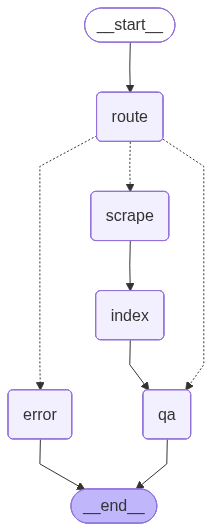

In [10]:
from langgraph.graph import StateGraph, END

graph = StateGraph(GraphState)

graph.add_node("route", route_node)
graph.add_node("scrape", scrape_node)
graph.add_node("index", index_node)
graph.add_node("qa", qa_node)
graph.add_node("error", error_node)

graph.set_entry_point("route")

graph.add_conditional_edges(
    "route",
    route_decision,
    {
        "scrape": "scrape",
        "qa": "qa",
        "error": "error"
    }
)

graph.add_edge("scrape", "index")
graph.add_edge("index", "qa")
graph.add_edge("qa", END)
graph.add_edge("error", END)

compiled_graph = graph.compile()
compiled_graph

# 10: Run Full Graph (Cold Start)

In [11]:
result = compiled_graph.invoke({
    "url": "https://example.com",
    "question": "What is this page about?",
    "page_content": None,
    "vector_store": None,
    "answer": None,
    "sources": None
})

print("📌 Answer:")
print(result["answer"])

print("\n📚 Sources:", len(result["sources"]))

🧭 Routing decision...
🕷️ Scraping page...
📦 Building FAISS index...
🤖 Answering question...
📌 Answer:
This page is about an example domain used for documentation purposes, where you can test and demonstrate website features without requiring permission.

📚 Sources: 1


# 11: Run Graph Again (Index Reuse)

In [12]:
result2 = compiled_graph.invoke({
    "url": "https://example.com",
    "question": "Is this page for testing?",
    "page_content": None,
    "vector_store": result["vector_store"],
    "answer": None,
    "sources": None
})

print("📌 Answer:")
print(result2["answer"])

🧭 Routing decision...
🤖 Answering question...
📌 Answer:
❌ Answer not found in the provided page content.
